In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
sys.path.append("../..")
sys.path.append("../../..")

# 1. Open dataset

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
path = "/data/pcpe_01.csv"
df = pd.read_csv(path, delimiter=';')
df

,NUMERO_CASO,NUMERO_BANCO,NUMERO_AGENCIA,NUMERO_CONTA,TIPO,CPF_CNPJ_TITULAR,CNAB,CNAB=101,CNAB=119,CNAB=120,...,NUMERO_AGENCIA_OD,NUMERO_CONTA_OD,I-a,I-b,I-c,I-d,I-e,DIA_LANCAMENTO,MES_LANCAMENTO,ANO_LANCAMENTO
0,CASO-01-L1K4U4,O6Y,1965,153602,2,ZS9104223348,218,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2017
1,CASO-01-L1K4U4,O6Y,1965,153602,2,ZS9104223348,218,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2017
2,CASO-01-L1K4U4,L6X,742,810886,2,RJ3341718546,211,0,0,0,...,75,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
3,CASO-01-L1K4U4,L6X,742,810886,2,RJ3341718546,211,0,0,0,...,75,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
4,CASO-01-L1K4U4,W5Y,554,902093,1,IK6356601049,201,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138300,CASO-01-L1K4U4,O9A,490,296083,1,KO2307484082,206,0,0,0,...,490,296083.0,NaN,NaN,NaN,NaN,NaN,1,3,2021
138301,CASO-01-L1K4U4,O9A,490,296083,1,KO2307484082,102,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2021
138302,CASO-01-L1K4U4,O9A,490,296083,2,KO2307484082,102,0,0,0,...,490,296083.0,NaN,NaN,NaN,NaN,NaN,1,3,2021
138303,CASO-01-L1K4U4,O6Y,5776,191834,1,KO2307484082,205,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,1,3,2021


In [6]:
from publications.lacci2024.analysis import LacciAnalysis


# 2. Descriptive Statistics

In [7]:
lacci_analysis = LacciAnalysis(df) 
df_descriptive = lacci_analysis.get_results_descriptive()
print(df_descriptive.to_latex())


\begin{tabular}{lrr}
\toprule
Typology & I-d & None \\
\midrule
Accounts & 11 & 177 \\
Individuals/Companies & 6 & 35 \\
Transactions & 10446 & 127859 \\
\bottomrule
\end{tabular}



# 3. Data Spliting

In [8]:
from mlex import PastFutureSplit
split = PastFutureSplit()
X, y = lacci_analysis.get_X_y()
X_train, X_test, y_train, y_test = split.train_test_split(X, y)

2024-05-31 21:20:38.155965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 4. Model Training

In [9]:
from mlex import (
    SimplePipeline,
    SimpleRNNModel,
    SimpleLSTMModel,
    SimpleGruModel,
)

In [10]:
from mlex import (
    SequenceTransfomer
)

In [11]:
sequence = SequenceTransfomer()
data_train = sequence.transform(X_train, y_train)
data_test = sequence.transform(X_test, y_test)
data_train

2024-05-31 21:20:41.352688: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 21:20:41.353077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-31 21:20:41.358929: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 45), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [12]:
model_rnn = SimpleRNNModel(X_train.shape)
model_lstm = SimpleLSTMModel(X_train.shape)
model_gru = SimpleGruModel(X_train.shape)

pipelines = []
models = [model_rnn, model_lstm, model_gru]
# models = [model]

for m in models:
    pipeline = SimplePipeline(final_model=m.get_model())
    history = m.fit(data_train)
    pipelines.append(m)

Epoch 1/10


2024-05-31 21:20:42.857335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-05-31 21:20:42.857712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [69152,1]
	 [[{{node Placeholder/_20}}]]
2024-05-31 21:20:44.254102: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x57f51540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-31 21:20:44.254138: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 SUP

541/541 [==============================] - 10s 15ms/step - loss: 0.2800 - acc: 0.8924 - auc: 0.8142
Epoch 2/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2444 - acc: 0.9020 - auc: 0.8701
Epoch 3/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2308 - acc: 0.9072 - auc: 0.8873
Epoch 4/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2224 - acc: 0.9102 - auc: 0.8966
Epoch 5/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2171 - acc: 0.9125 - auc: 0.9016
Epoch 6/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2136 - acc: 0.9140 - auc: 0.9048
Epoch 7/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2109 - acc: 0.9153 - auc: 0.9073
Epoch 8/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2084 - acc: 0.9164 - auc: 0.9099
Epoch 9/10
541/541 [==============================] - 8s 15ms/step - loss: 0.2059 - acc: 0.9176 - auc: 0.9122
Epoch 10/10
541/541 

2024-05-31 21:22:05.831769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 21:22:05.832699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 21:22:05.833338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

541/541 [==============================] - 5s 5ms/step - loss: 0.2968 - acc: 0.8915 - auc_1: 0.7778
Epoch 2/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2513 - acc: 0.9005 - auc_1: 0.8616
Epoch 3/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2373 - acc: 0.9049 - auc_1: 0.8795
Epoch 4/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2257 - acc: 0.9090 - auc_1: 0.8926
Epoch 5/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2169 - acc: 0.9130 - auc_1: 0.9017
Epoch 6/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2104 - acc: 0.9165 - auc_1: 0.9082
Epoch 7/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2050 - acc: 0.9189 - auc_1: 0.9134
Epoch 8/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2003 - acc: 0.9210 - auc_1: 0.9180
Epoch 9/10
541/541 [==============================] - 3s 5ms/step - loss: 0.1956 - acc: 0.9221 - auc_1: 0.9225
Epoch 10/10


2024-05-31 21:22:36.148526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 21:22:36.149393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 21:22:36.150043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

541/541 [==============================] - 5s 5ms/step - loss: 0.3113 - acc: 0.8872 - auc_2: 0.7453
Epoch 2/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2673 - acc: 0.8933 - auc_2: 0.8368
Epoch 3/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2532 - acc: 0.8986 - auc_2: 0.8590
Epoch 4/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2388 - acc: 0.9049 - auc_2: 0.8776
Epoch 5/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2268 - acc: 0.9098 - auc_2: 0.8911
Epoch 6/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2196 - acc: 0.9133 - auc_2: 0.8985
Epoch 7/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2147 - acc: 0.9154 - auc_2: 0.9032
Epoch 8/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2103 - acc: 0.9178 - auc_2: 0.9076
Epoch 9/10
541/541 [==============================] - 3s 5ms/step - loss: 0.2063 - acc: 0.9198 - auc_2: 0.9116
Epoch 10/10


In [13]:
def get_y_pred_actual(y_pred_score, y_test, sequence_length):
    y_pred = y_pred_score > np.quantile(y_pred_score, 0.95)
    y_true = y_test[:-sequence_length+1]
    return y_true, y_pred

In [14]:
sequence_length = 10
list_y_pred_score = []
list_ys_true_pred = []
for p in pipelines:
    y_pred_score = p.predict(data_test)
    y_true, y_pred = get_y_pred_actual(y_pred_score, y_test, sequence_length)
    list_ys_true_pred.append((y_true, y_pred, y_pred_score))

  1/541 [..............................] - ETA: 1:45

2024-05-31 21:23:06.348272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int32
	 [[{{node Placeholder/_14}}]]
2024-05-31 21:23:06.348832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_20' with dtype double and shape [69152,1]
	 [[{{node Placeholder/_20}}]]


541/541 [==============================] - 2s 4ms/step


2024-05-31 21:23:09.037852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 21:23:09.038839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 21:23:09.039510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

541/541 [==============================] - 2s 2ms/step


2024-05-31 21:23:10.814067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-31 21:23:10.814981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-31 21:23:10.815647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

541/541 [==============================] - 2s 2ms/step


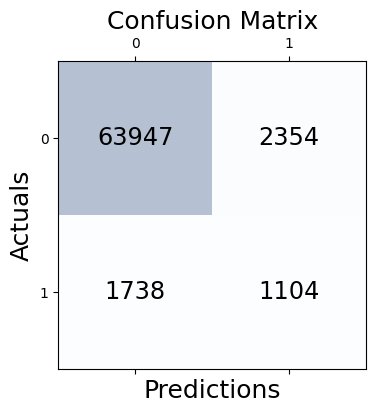

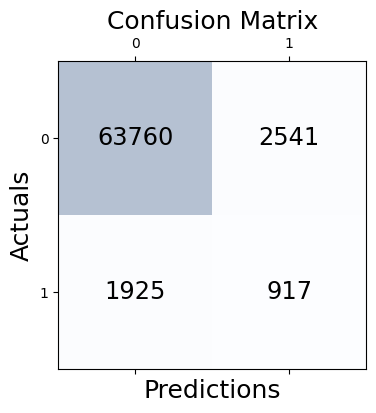

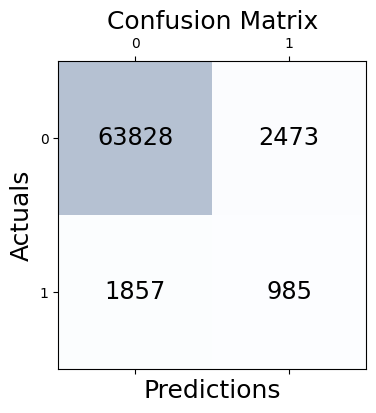

In [15]:
from publications.lacci2024.plotter import Plotter
plotter = Plotter()
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    plotter.plot_matrix(y_true, y_pred)


In [27]:
from itertools import cycle
names = ['RNN', 'LSTM', 'GRU']
name_cycler = cycle(names)

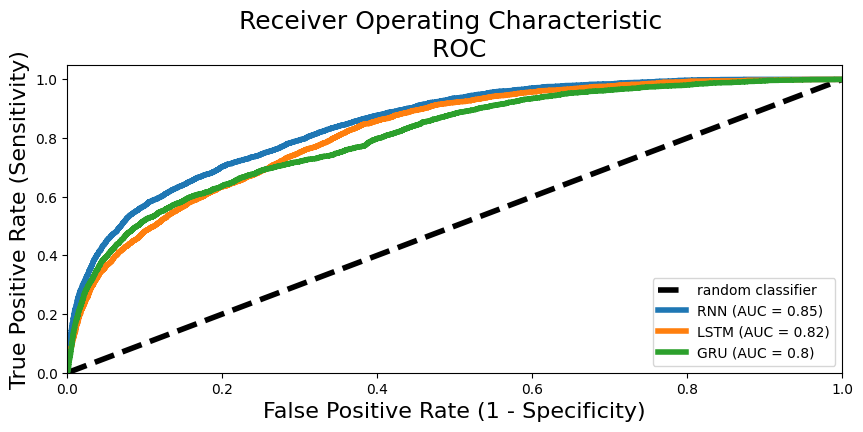

In [53]:
from sklearn import metrics
import cycler
title = "ROC"
fig, ax = plt.subplots()
ax.plot([0,1], [0,1], "k--",linewidth=4, label='random classifier')
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr,  linewidth=4, label=f"{next(name_cycler)} (AUC = {round(auc,2) })")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate (1 - Specificity)", fontsize=16)
ax.set_ylabel("True Positive Rate (Sensitivity)", fontsize=16)
ax.set_title(f"Receiver Operating Characteristic \n {title}", fontsize=18)
ax.legend(loc="lower right")
# plt.savefig("roc.pdf")

plt.show()

In [349]:
def roc(y_true, y_pred_score):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_score)
    auc = metrics.auc(fpr, tpr)
return auc

In [18]:
import scipy.stats as st

In [23]:
def roc_samples(y_t, y_s):
    N = len(y_t)
    rocs = []
    for b in range(30):
        choices = np.random.choice(N, size=N)
        ys_t = y_t[choices]
        ys_p = y_s[choices]
        fpr, tpr, thresholds = metrics.roc_curve(ys_t, ys_p)
        auc = metrics.auc(fpr, tpr)
        rocs.append(auc)
    return rocs

cis = []
for y_true, y_pred, y_pred_score in list_ys_true_pred:
    rocs = roc_samples(y_true, y_pred_score)
    roc_mean = np.mean(rocs)
    roc_std = np.std(rocs)
    roc_lb = roc_mean - 1.96 * roc_std
    roc_up = roc_mean + 1.96 * roc_std
    ci = f'{round(roc_mean, 2)} {round(roc_lb, 2), round(roc_up, 2)}'
    cis.append(ci)


In [24]:
cis

['0.85 (0.84, 0.85)', '0.82 (0.81, 0.83)', '0.8 (0.8, 0.81)']

In [25]:
import pandas as pd

In [42]:
df_ci = pd.DataFrame({
        "Model": names,
        "95% Confidence Interval": cis
    })
print(df_ci.to_latex(index=False, escape=True))

\begin{tabular}{ll}
\toprule
Model & 95\% Confidence Interval \\
\midrule
RNN & 0.85 (0.84, 0.85) \\
LSTM & 0.82 (0.81, 0.83) \\
GRU & 0.8 (0.8, 0.81) \\
\bottomrule
\end{tabular}

